In [5]:
from nilearn import image, input_data, masking, plotting, signal
from nilearn.plotting import plot_roi, plot_epi, show
import numpy as np
import matplotlib.pylab as plt
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import detrend
import os.path as op
from utilities import files
%matplotlib qt

In [6]:
path = "/home/mszul/datasets/braindyn_localizer"
participants = files.get_folders_files(path)[0]
participant = participants[0]
_id = participant.split("/")[-1]

mask = "/home/mszul/git/BrainDyn_ANALYSIS/masks/hocp-Occipital_Pole.nii.gz"
nifti_file = op.join(
    participant, 
    "func", 
    "{}_task-flicker_dir-AP_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(_id)
)
brain_mask = op.join(
    participant,
    "func",
    "{}_task-flicker_dir-AP_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz".format(_id)
)
t1 = op.join(
    participant,
    "anat",
    "{}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz".format(_id)
)

nifti = image.smooth_img(nifti_file, fwhm=None)
roi_op = image.smooth_img("/home/mszul/git/BrainDyn_ANALYSIS/masks/hocp-Occipital_Pole.nii.gz", fwhm=None)
roi_op = image.resample_to_img(roi_op, nifti, fill_value=0, clip=True, interpolation="nearest")
roi_ffg = image.smooth_img("/home/mszul/git/BrainDyn_ANALYSIS/masks/hocp-Occipital_Fusiform_Gyrus.nii.gz", fwhm=None)
roi_ffg = image.resample_to_img(roi_ffg, nifti, fill_value=0, clip=True, interpolation="nearest")
mean_nifti = image.mean_img(nifti)

In [7]:
nifti_voxels = masking.apply_mask(nifti, roi_op, smoothing_fwhm=3)
time = np.arange(nifti_voxels.shape[0])*1.3
nyquist_freq = (1/1.3)/2
nifti_voxels = signal._detrend(nifti_voxels, type="linear")

In [36]:
TR = 1.3
n = 200
sample_rate = 1/TR

timecourse = nifti_voxels[:,12][:200]
fft_Y = fft(timecourse)
fft_FREQ = fftfreq(fft_Y.shape[0], TR)
fft_Y = fftshift(np.abs(fft_Y))
fft_FREQ = fftshift(fft_FREQ)
fft_Y = fft_Y[np.where(fft_FREQ >= 0)]
fft_FREQ = fft_FREQ[np.where(fft_FREQ >= 0)]

In [49]:
f, ax = plt.subplots(figsize=(16, 6))
ax.plot(fft_FREQ, fft_Y, lw=0.5, c="black")
ax.scatter(fft_FREQ, fft_Y, s=3, color="black")
ax.axvline(0.0385, lw=0.5, c="green")
target_freq_ix = np.where(fft_FREQ <= 0.0385)[0][-1]

skipbins = 2
numbins  = 5

tf_below_ix_r = np.arange(target_freq - skipbins - numbins, target_freq - numbins)
tf_above_ix_r = np.arange(target_freq + skipbins, target_freq + skipbins + numbins)
tf_around_ix_r = np.concatenate([tf_below_ix_r, tf_above_ix_r])
tf_around_ix_r.sort()

# numerator
tf_value = fft_Y[target_freq]
# denominator
tf_surround = np.take(fft_Y, tf_around_ix_r, axis=0)

snr_pow = tf_value/ tf_surround.mean()
print(snr_pow)

ax.axvline(fft_FREQ[target_freq_ix], lw=0.5, c="red")

1.9460849


In [51]:
snrscores = []
for voxel in range(nifti_voxels.shape[1]):
    timecourse = nifti_voxels[:, voxel][:200]
    fft_Y = fft(timecourse)
    fft_FREQ = fftfreq(fft_Y.shape[0], TR)
    fft_Y = fftshift(np.abs(fft_Y))
    fft_FREQ = fftshift(fft_FREQ)
    fft_Y = fft_Y[np.where(fft_FREQ >= 0)]
    fft_FREQ = fft_FREQ[np.where(fft_FREQ >= 0)]
    skipbins = 2
    numbins  = 5

    tf_below_ix_r = np.arange(target_freq - skipbins - numbins, target_freq - numbins)
    tf_above_ix_r = np.arange(target_freq + skipbins, target_freq + skipbins + numbins)
    tf_around_ix_r = np.concatenate([tf_below_ix_r, tf_above_ix_r])
    tf_around_ix_r.sort()

    # numerator
    tf_value = fft_Y[target_freq]
    # denominator
    tf_surround = np.take(fft_Y, tf_around_ix_r, axis=0)

    snr_pow = tf_value/ tf_surround.mean()
    snrscores.append(snr_pow)


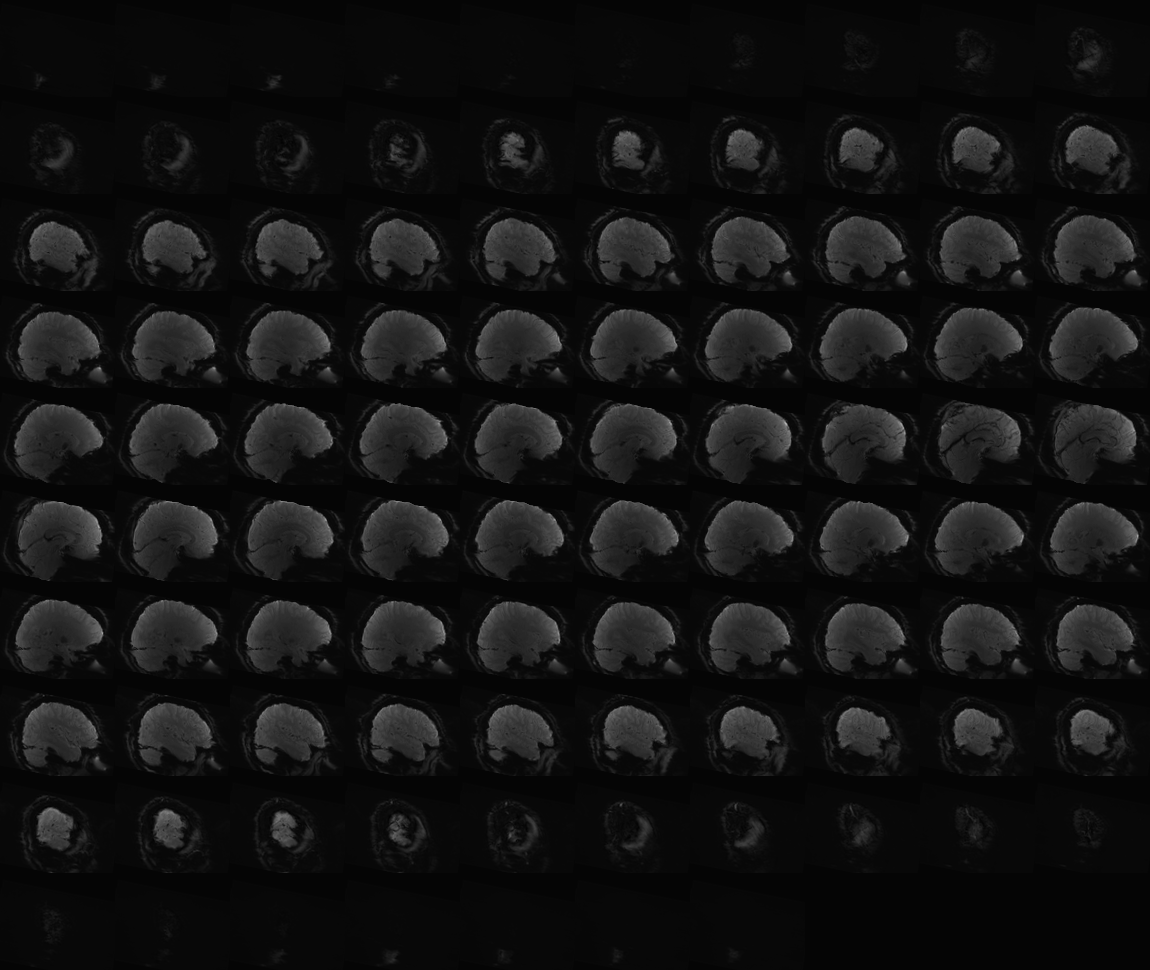
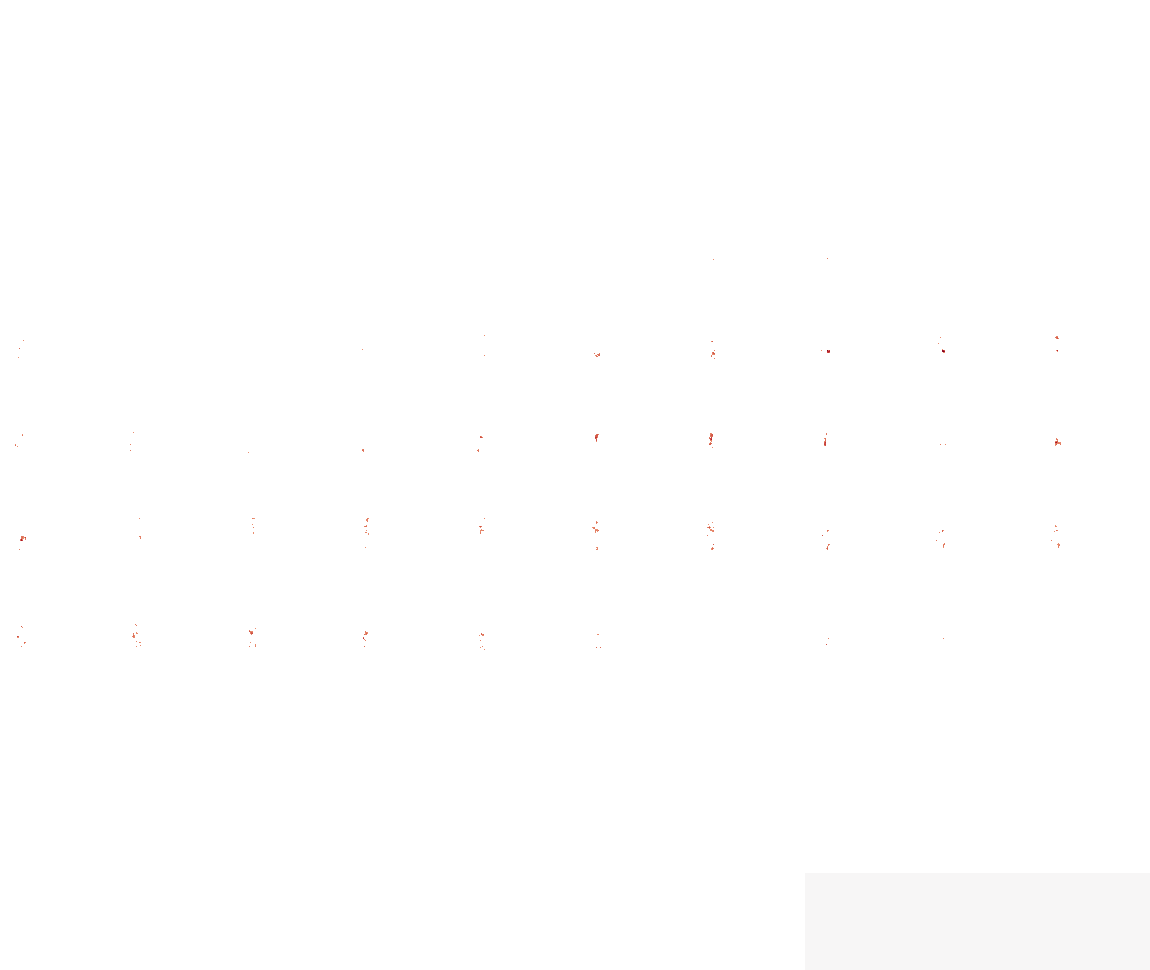

In [58]:
mask_ = masking.unmask(np.array(snrscores), roi_op)

plotting.view_img(mask_, bg_img=mean_nifti, cmap="RdBu_r", threshold=6, black_bg=True, colorbar=True)